# Using LLMs to simulate human common sense


In [1]:
# Change to home directory
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

import matplotlib

# Set default font to Arial
matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams["font.sans-serif"] = "Arial"

## Load human data


In [3]:
# Human ratings
# Do you agree with this statement?
individual = pd.read_csv("data/results/individual_ratings.csv", index_col=0)

# Do you think most people would agree with this statement?
group = pd.read_csv("data/results/group_ratings.csv", index_col=0)

# Majority voting (skip participants who didn't answer)
avg_vote_per_q = individual.mean(axis=1, skipna=True)
maj_i = (avg_vote_per_q >= 0.5).astype(int)

# Majority of "others agree" answers by humans
maj_others = (group.mean(1, skipna=True) >= 0.5).astype(int)

### Statement-level commonsensicality


In [4]:
# Statement: consensus
c_i = 2 * np.abs(individual.mean(1) - 0.5)

# Statement: awareness
a_i = pd.Series(
    [(group.loc[i].dropna().astype(int) == maj_i[i]).mean() for i in maj_i.index],
    index=maj_i.index,
)

# Statement: commonsensicality
m_i = np.sqrt(c_i * a_i)

### Individual-level commonsensicality


In [5]:
# Person: consensus
C_j = pd.Series(
    [
        (
            individual.loc[:, j].dropna().astype(int)
            == maj_i.loc[individual.loc[:, j].dropna().index]
        ).mean()
        for j in individual.columns
    ],
    index=individual.columns,
)

# Person: awareness
A_j = pd.Series(
    [
        (
            group.loc[:, j].dropna().astype(int)
            == maj_i.loc[group.loc[:, j].dropna().index]
        ).mean()
        for j in group.columns
    ],
    index=group.columns,
)

# Person: commonsensicality
M_j = np.sqrt(C_j * A_j)

## Load model data


In [6]:
from src.utilities import load_annotations_gpt
from src.utilities import load_results_hf
from src.utilities import load_results_freq
from src.utilities import load_results_gpt5

all_models = {}

all_models["GPT-3.5"] = load_annotations_gpt(
    model_name="gpt-3.5-turbo-0125", trial_no=1, verbose=True
)
all_models["GPT-4-0125"] = load_annotations_gpt(
    model_name="gpt-4-0125-preview", trial_no=1, verbose=True
)
all_models["GPT-4-0409"] = load_annotations_gpt(
    model_name="gpt-4-turbo-2024-04-09", trial_no=1, verbose=True
)
all_models["GPT-4o"] = load_annotations_gpt(
    model_name="gpt-4o-2024-05-13", trial_no=1, verbose=True
)
all_models["GPT-5"] = load_results_gpt5(model_name="gpt-5-2025-08-07", verbose=True)

all_models["LLaMA-2-7B"] = load_results_hf(
    model_name="meta-llama--Llama-2-7b-chat-hf", verbose=True
)
all_models["LLaMA-2-13B"] = load_results_hf(
    model_name="meta-llama--Llama-2-13b-chat-hf", verbose=True
)
all_models["LLaMA-2-70B"] = load_results_hf(
    model_name="meta-llama--Llama-2-70b-chat-hf", verbose=True
)

all_models["LLaMA-3-8B"] = load_results_hf(
    model_name="meta-llama--Meta-Llama-3-8B-Instruct", verbose=True
)
all_models["LLaMA-3-70B"] = load_results_hf(
    model_name="meta-llama--Meta-Llama-3-70B-Instruct", verbose=True
)

all_models["Flan-T5-Small"] = load_results_hf(
    model_name="google--flan-t5-small", verbose=True
)
all_models["Flan-T5-Base"] = load_results_hf(
    model_name="google--flan-t5-base", verbose=True
)
all_models["Flan-T5-Large"] = load_results_hf(
    model_name="google--flan-t5-large", verbose=True
)
all_models["Flan-T5-XL"] = load_results_hf(
    model_name="google--flan-t5-xl", verbose=True
)
all_models["Flan-T5-XXL"] = load_results_hf(
    model_name="google--flan-t5-xxl", verbose=True
)

all_models["Gemma-2B"] = load_results_hf(model_name="google--gemma-2b-it", verbose=True)
all_models["Gemma-7B"] = load_results_hf(model_name="google--gemma-7b-it", verbose=True)

all_models["Gemini Pro 1.0"] = load_results_freq(model_name="gemini-pro", verbose=True)

all_models["Mistral-7B"] = load_results_hf(
    model_name="mistralai--Mistral-7B-Instruct-v0.2", verbose=True
)
all_models["Mixtral-8x7B"] = load_results_hf(
    model_name="mistralai--Mixtral-8x7B-Instruct-v0.1", verbose=True
)
all_models["Mixtral-8x22B"] = load_results_hf(
    model_name="mistralai--Mixtral-8x22B-Instruct-v0.1", verbose=True
)

all_models["Mistral-Large"] = load_results_freq(
    model_name="mistral-large-latest", verbose=True
)

all_models["OLMo-7B"] = load_results_hf(
    model_name="allenai--OLMo-7B-Instruct", verbose=True
)

all_models["Falcon-7B"] = load_results_hf(
    model_name="tiiuae--falcon-7b-instruct", verbose=True
)
all_models["Falcon-40B"] = load_results_hf(
    model_name="tiiuae--falcon-40b-instruct", verbose=True
)
all_models["Falcon-180B"] = load_results_hf(
    model_name="tiiuae--falcon-180B-chat", verbose=True
)

all_models["Claude 3 Opus"] = load_results_freq(
    model_name="claude-3-opus", verbose=True
)
all_models["Claude 3 Sonnet"] = load_results_freq(
    model_name="claude-3-sonnet", verbose=True
)
all_models["Claude 3 Haiku"] = load_results_freq(
    model_name="claude-3-haiku", verbose=True
)

all_models["DBRX"] = load_results_hf(
    model_name="databricks--dbrx-instruct", verbose=True
)

all_models["Qwen2-0.5B"] = load_results_hf(
    model_name="Qwen--Qwen2-0.5B-Instruct", verbose=True
)
all_models["Qwen2-1.5B"] = load_results_hf(
    model_name="Qwen--Qwen2-1.5B-Instruct", verbose=True
)
all_models["Qwen2-7B"] = load_results_hf(
    model_name="Qwen--Qwen2-7B-Instruct", verbose=True
)
all_models["Qwen2-57B"] = load_results_hf(
    model_name="Qwen--Qwen2-57B-A14B-Instruct", verbose=True
)
all_models["Qwen2-72B"] = load_results_hf(
    model_name="Qwen--Qwen2-72B-Instruct", verbose=True
)

Question q1 has 50 repetitions


Question q2 has 50 repetitions


Question q3 has 50 repetitions


Question q1 has 23 repetitions


Question q2 has 23 repetitions


Question q3 has 23 repetitions


Question q1 has 23 repetitions


Question q2 has 23 repetitions


Question q3 has 23 repetitions


Question q1 has 23 repetitions


Question q2 has 23 repetitions


Question q3 has 23 repetitions


Question q1 has 23 repetitions


Question q2 has 23 repetitions


Question q3 has 23 repetitions


## Agreement between model-simulated population and human population


### Statement commonsensicality from model outputs


In [7]:
def get_probs(q_answers):
    q_answers = q_answers[["yes", "no", "other"]]

    q_answers = q_answers.to_numpy()
    other = q_answers[:, 2]
    q_answers[:, 0] += other / 2
    q_answers[:, 1] += other / 2
    q_answers = q_answers[:, 0:2]
    q_answers /= q_answers.sum(1, keepdims=True)

    q_answers = pd.DataFrame(q_answers, columns=["yes", "no"], index=individual.index)
    return q_answers

In [8]:
def statement_comm(model_name):
    q1 = get_probs(all_models[model_name]["q1"])
    q2 = get_probs(all_models[model_name]["q2"])

    consensus = 2 * np.abs(q1["yes"] - 0.5) * 100

    awareness = np.where(q1["yes"] >= 0.5, q2["yes"], q2["no"]) * 100
    commonsensicality = np.sqrt(consensus * awareness)
    return np.array(consensus), np.array(awareness), np.array(commonsensicality)

In [9]:
statement_comm_all = pd.DataFrame(
    [],
    columns=["consensus", "awareness", "commonsensicality"],
    index=["Humans"] + sorted(all_models.keys()),
)
statement_comm_all.loc["Humans", "consensus"] = np.array(c_i) * 100
statement_comm_all.loc["Humans", "awareness"] = np.array(a_i) * 100
statement_comm_all.loc["Humans", "commonsensicality"] = np.array(m_i) * 100

for model_name in all_models.keys():
    consensus, awareness, commonsensicality = statement_comm(model_name)
    statement_comm_all.loc[model_name, "consensus"] = consensus
    statement_comm_all.loc[model_name, "awareness"] = awareness
    statement_comm_all.loc[model_name, "commonsensicality"] = commonsensicality

In [10]:
statement_comm_all

,consensus,awareness,commonsensicality
Humans,"[100.0, 33.33333333333333, 100.0, 100.0, 100.0...","[100.0, 66.66666666666666, 95.45454545454545, ...","[100.0, 47.14045207910316, 97.70084209183945, ..."
Claude 3 Haiku,"[100.0, 100.0, 100.0, 100.0, 91.30434782608697...","[100.0, 91.30434782608695, 100.0, 100.0, 100.0...","[100.0, 95.55330859059092, 100.0, 100.0, 95.55..."
Claude 3 Opus,"[100.0, 91.30434782608697, 100.0, 91.304347826...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 95.55330859059092, 100.0, 95.553308590..."
Claude 3 Sonnet,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 0.0, 100.0, 0.0, 100.0, 100.0, 100.0, ...","[100.0, 0.0, 100.0, 0.0, 100.0, 100.0, 100.0, ..."
DBRX,"[99.96460740274884, 87.98737935721874, 99.9843...","[99.99322349121513, 1.7464944161474705, 99.992...","[99.97891442316546, 12.396348927762228, 99.988..."
Falcon-180B,"[63.57879638671875, 10.9619140625, 71.26464843...","[85.97683906555176, 67.706298828125, 87.876701...","[73.93445708816967, 27.24317582889063, 79.1359..."
Falcon-40B,"[15.5712328851223, 11.70240268111229, 17.03280...","[62.592882476747036, 59.93484556674957, 59.268...","[31.21935857759603, 26.483611865687454, 31.772..."
Falcon-7B,"[62.94965669512749, 48.20539951324463, 74.1330...","[77.8696570545435, 74.15707856416702, 79.46810...","[70.0133428608492, 59.78939369922345, 76.75423..."
Flan-T5-Base,"[22.032609581947327, 5.028530955314636, 38.118...","[56.74458593130112, 55.670441687107086, 70.464...","[35.358610093068116, 16.731423708688283, 51.82..."
Flan-T5-Large,"[75.18389746546745, 51.18948668241501, 97.0660...","[72.73371368646622, 62.97563910484314, 96.6440...","[73.94865835216987, 56.777554009255645, 96.854..."


## Comparing statement commonsensicality by humans and by a model


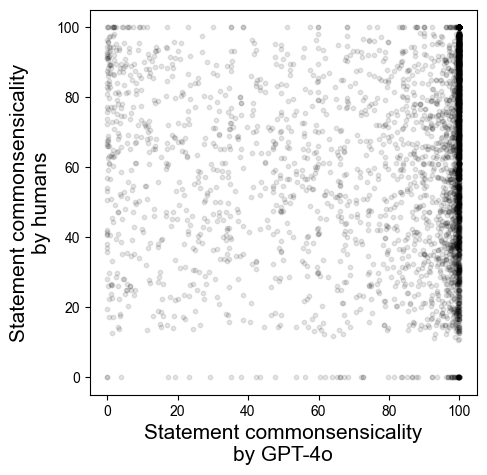

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
model_name = "GPT-4o"
ax.scatter(
    statement_comm_all.loc[model_name, "commonsensicality"],
    statement_comm_all.loc["Humans", "commonsensicality"],
    color="black",
    s=10,
    alpha=0.1,
)
ax.set_xlabel(f"Statement commonsensicality\nby {model_name}", size=15)
ax.set_ylabel(f"Statement commonsensicality\nby humans", size=15)
plt.show()

In [12]:
model_to_color = {
    "GPT-3.5": "forestgreen",
    "GPT-4-0125": "forestgreen",
    "GPT-4-0409": "forestgreen",
    "GPT-4o": "forestgreen",
    "GPT-5": "forestgreen",
    "LLaMA-2-7B": "indianred",
    "LLaMA-2-13B": "indianred",
    "LLaMA-2-70B": "indianred",
    "LLaMA-3-8B": "indianred",
    "LLaMA-3-70B": "indianred",
    "Flan-T5-Small": "royalblue",
    "Flan-T5-Base": "royalblue",
    "Flan-T5-Large": "royalblue",
    "Flan-T5-XL": "royalblue",
    "Flan-T5-XXL": "royalblue",
    "Gemma-2B": "chocolate",
    "Gemma-7B": "chocolate",
    "Gemini Pro 1.0": "chocolate",
    "Mistral-7B": "darkviolet",
    "Mixtral-8x7B": "darkviolet",
    "Mixtral-8x22B": "darkviolet",
    "Mistral-Large": "darkviolet",
    "OLMo-7B": "goldenrod",
    "Falcon-7B": "teal",
    "Falcon-40B": "teal",
    "Falcon-180B": "teal",
    "Claude 3 Haiku": "olivedrab",
    "Claude 3 Sonnet": "olivedrab",
    "Claude 3 Opus": "olivedrab",
    "DBRX": "crimson",
    "Qwen2-0.5B": "lightseagreen",
    "Qwen2-1.5B": "lightseagreen",
    "Qwen2-7B": "lightseagreen",
    "Qwen2-57B": "lightseagreen",
    "Qwen2-72B": "lightseagreen",
}

In [13]:
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + "$\\times 10^{" + str(b) + "}$"

In [14]:
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import re
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm


def plot_comm_calib_with_marginals(model_name, save=False):

    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
    # the size of the marginal Axes and the main Axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(8, 1.5),
        height_ratios=(8, 1.5),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.15,
    )
    # Create the Axes.
    ax = fig.add_subplot(gs[0, 0])

    model_scores = statement_comm_all.loc[model_name, "commonsensicality"]
    human_scores = statement_comm_all.loc["Humans", "commonsensicality"]

    colors = [
        np.array((235, 235, 235)) / 256,  # RGB values for gray
        model_to_color[model_name],
    ]
    custom_cmap = LinearSegmentedColormap.from_list("gray_orange", colors)

    hb = ax.hexbin(
        x=model_scores,
        y=human_scores,
        C=None,
        gridsize=40,
        mincnt=1,
        cmap=custom_cmap,
        xscale="linear",
        yscale="linear",
        bins="log",
        vmin=1,
        vmax=300,
        extent=(0, 100, 0, 100),
        marginals=False,
    )

    # Report out-of-sample R^2
    metrics = []
    X = pd.DataFrame(model_scores)
    y = pd.DataFrame(human_scores)

    # KFold split
    kf = KFold(n_splits=50, shuffle=True, random_state=100)
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X)), disable=True):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        # R2
        r2 = r2_score(y_true=y_test, y_pred=y_pred)
        metrics.append(r2)

    ax.text(
        x=50,
        y=5.3,
        s=f"$R^2$ = {re.sub('0(?=[.])', '', ('%0.2f' % np.mean(metrics)))} $\\pm$ {re.sub('0(?=[.])', '', ('%0.2f' % np.std(metrics)))}",
        va="center",
        ha="center",
        size=21,
    )

    ax.set_xlim([-5, 105])
    ax.set_ylim([-5, 105])
    ax.plot([-100, 200], [-100, 200], color="black", linewidth=1, alpha=0.5)

    # ax.set_xlabel(f"Statement commonsensicality to silicon samples ($m_i^m$, %)", size=12, labelpad=100)
    # ax.set_ylabel(f"Statement commonsensicality\n to humans ($m_i^h$, %)", size=17)

    if model_name in [
        "GPT-5",
        "GPT-4-0409",
        "GPT-4-0125",
        "GPT-4o",
        "GPT-3.5",
        "Claude 3 Haiku",
        "Claude 3 Sonnet",
        "Claude 3 Opus",
        "Mistral-Large",
        "Gemini Pro 1.0",
    ]:
        bold = True
    else:
        bold = False

    ax.text(
        x=-5,
        y=112,
        s=model_name,
        color=model_to_color[model_name],
        size=23,
        fontweight="bold" if bold else None,
        va="center",
        ha="left",
    )

    ax.set_xticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
    ax.set_yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
    ax.tick_params(axis="both", direction="in", size=4, labelsize=18)
    # ax.set_aspect("equal")

    cbaxes = fig.add_axes([0.605, 0.94, 0.15, 0.025])
    cb = plt.colorbar(
        hb,
        cax=cbaxes,
        ticks=[1, 10, 100, 500],
        orientation="horizontal",
        pad=0.05,
        aspect=50,
        fraction=0.1,
    )

    cb.outline.set_visible(False)
    cb.ax.tick_params(size=7, direction="in", which="major", color="white")
    cb.ax.tick_params(size=0, which="minor")

    cb.ax.set_xticklabels([1, 10, 100, 1000], size=13)

    for spine in ax.spines.values():
        spine.set_edgecolor(np.array((150, 150, 150)) / 256)

    sns.regplot(
        x=model_scores,
        y=human_scores,
        scatter=False,
        line_kws=dict(color=model_to_color[model_name], linewidth=3),
        ax=ax,
    )

    ax_main = ax

    ax = fig.add_subplot(gs[1, 0], sharex=ax_main)
    bars, ints = np.histogram(model_scores, bins=np.linspace(0, 100, num=41))
    ints = [np.mean([ints[i], ints[i + 1]]) for i in range(len(ints) - 1)]
    bars = bars / bars.sum()
    # ax_main.bar(ints, bars + 1, width=2.2, color='r', alpha=0.8)
    ax.bar(ints, bars, width=2.2, color=model_to_color[model_name], alpha=0.9)
    ax.invert_yaxis()
    sns.despine(ax=ax, top=True, bottom=True, left=True, right=True)
    ax.set_yticks([])
    ax.tick_params(size=0, labelbottom=False, axis="both")

    ax = fig.add_subplot(gs[0, 1], sharey=ax_main)
    bars, ints = np.histogram(human_scores, bins=np.linspace(0, 100, num=41))
    ints = [np.mean([ints[i], ints[i + 1]]) for i in range(len(ints) - 1)]
    bars = bars / bars.sum()
    ax.barh(ints, bars, height=2.2, color="k", alpha=0.9)
    # ax.set_yticks([])
    ax.tick_params(size=0, labelbottom=False, axis="both")
    sns.despine(ax=ax, top=True, bottom=True, left=True, right=True)
    ax.tick_params(size=0, labelbottom=False, axis="both", labelsize=0, labelcolor="w")

    for spine in ax.spines.values():
        spine.set_edgecolor(np.array((150, 150, 150)) / 256)

    if save:
        plt.savefig(
            f"figures/simulated_commonsensicality_calibration/{model_name}.pdf",
            bbox_inches="tight",
        )
        plt.close()
    else:
        plt.show()

In [15]:
!mkdir -p figures/simulated_commonsensicality_calibration

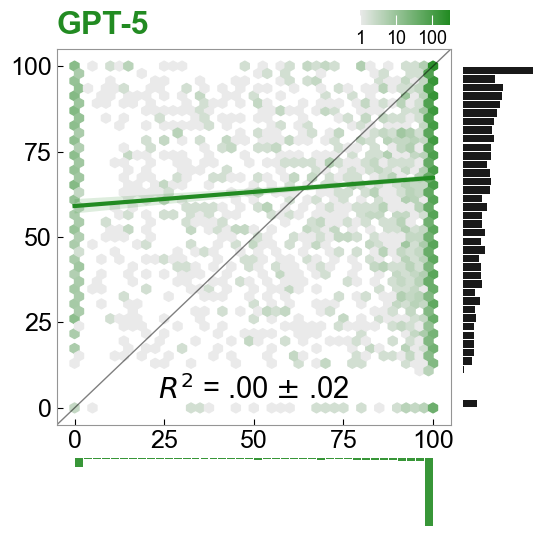

In [16]:
plot_comm_calib_with_marginals("GPT-5", save=False)

In [17]:
# Do the same for all models and save their plots
for model_name in tqdm(model_to_color.keys()):
    plot_comm_calib_with_marginals(model_name, save=True)

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:19<00:00,  1.81it/s]


In [18]:
statement_comm_only = pd.DataFrame(
    0.0, columns=statement_comm_all.index, index=np.arange(0, len(c_i))
)
for col in statement_comm_only.columns:
    statement_comm_only[col] = statement_comm_all.loc[col, "commonsensicality"]

In [19]:
statement_comm_only

,Humans,Claude 3 Haiku,Claude 3 Opus,Claude 3 Sonnet,DBRX,Falcon-180B,Falcon-40B,Falcon-7B,Flan-T5-Base,Flan-T5-Large,...,Mistral-7B,Mistral-Large,Mixtral-8x22B,Mixtral-8x7B,OLMo-7B,Qwen2-0.5B,Qwen2-1.5B,Qwen2-57B,Qwen2-72B,Qwen2-7B
0,100.000000,100.000000,100.000000,100.000000,99.978914,73.934457,31.219359,70.013343,35.358610,73.948658,...,57.113293,100.0,99.999908,99.999997,95.851047,61.961489,65.681890,99.999991,99.999999,99.999129
1,47.140452,95.553309,95.553309,0.000000,12.396349,27.243176,26.483612,59.789394,16.731424,56.777554,...,99.160699,100.0,91.093366,100.000000,97.393937,57.313323,50.554033,99.904408,99.999950,92.710919
2,97.700842,100.000000,100.000000,100.000000,99.988408,79.135973,31.772821,76.754231,51.826330,96.854798,...,99.999751,100.0,99.998915,100.000000,98.492094,88.899862,97.300419,99.999879,100.000000,99.998809
3,100.000000,100.000000,95.553309,0.000000,99.998478,68.366159,33.132684,69.596899,41.784502,91.774100,...,99.999534,100.0,99.999875,100.000000,97.987475,70.100671,92.161517,99.999817,100.000000,99.996931
4,100.000000,95.553309,100.000000,100.000000,99.993646,72.011467,15.696451,51.019606,50.686799,42.768569,...,99.999835,100.0,99.999650,99.999996,94.881926,41.507674,22.744220,99.929248,100.000000,99.998541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4402,78.140003,97.801929,97.801929,100.000000,99.996715,62.868599,8.462573,57.727915,57.335964,28.846981,...,99.999011,100.0,99.998438,100.000000,97.678469,55.183902,36.266257,99.999868,100.000000,99.996952
4403,28.177133,84.531400,97.801929,88.465174,49.203633,59.470137,14.045780,75.848019,40.459141,56.184376,...,99.982454,100.0,99.997878,99.999999,99.404758,82.504685,67.935870,99.989652,100.000000,99.979086
4404,58.655381,35.321906,100.000000,42.377367,17.560118,44.540674,19.676461,56.002679,38.514358,55.099844,...,21.026416,100.0,99.999875,6.712824,94.314158,34.781238,31.319511,32.687772,34.495690,99.912772
4405,100.000000,100.000000,100.000000,100.000000,99.980834,64.853542,6.896046,69.532470,48.303706,22.461106,...,99.997069,100.0,99.999824,99.999997,94.690636,65.623117,83.715371,99.999993,100.000000,99.999693


In [20]:
model_name = "Falcon-180B"
model_scores = statement_comm_all.loc[model_name, "commonsensicality"]
human_scores = statement_comm_all.loc["Humans", "commonsensicality"]
diff = model_scores - human_scores
diff.mean()

np.float64(-25.637313604375635)

## Predicting commonsensicality of humans by model


In [21]:
import numpy as np
import scipy.stats
from itertools import starmap


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


def sd(input, target, reduce=None, n_boot=1000):
    dist = list(
        starmap(
            lambda x, y: 0.5 * np.square(x - y).sum(),
            zip(input.to_numpy(), target.to_numpy()),
        )
    )
    dist = np.array(dist, dtype=float)
    sim = 1 - dist
    # sim = dist
    sim *= 100
    if reduce is None:
        return sim
    if reduce == "sum":
        return sim.sum()
    if reduce == "mean":
        return sim.mean()
    if reduce == "mean_ci":
        return mean_confidence_interval(sim)

In [22]:
from numba import njit, prange


@njit(parallel=True)
def sd_boot(input, target, reduce=None, n_boot=1000, seed=100):

    if seed is not None:
        np.random.seed(seed)

    input = input * 100
    target = target * 100

    # baseline 1: predicting 50% on all statements
    # baseline = (50 * np.ones_like(target))

    # baseline 2: predicting the mean over all statements
    baseline = target.mean() * np.ones_like(target)

    msd = np.sqrt(np.mean(np.square((input - target))))
    msd_baseline = np.sqrt(np.mean(np.square((baseline - target))))
    m = msd_baseline - msd

    values = np.empty(n_boot, dtype=float)
    all_idx = np.arange(target.shape[0])

    for boot_id in range(n_boot):
        idx_boot = np.random.choice(all_idx, all_idx.shape[0], replace=True)
        y_true_boot = target[idx_boot]
        y_pred_boot = input[idx_boot]

        msd = np.sqrt(np.mean(np.square((y_true_boot - y_pred_boot))))

        msd_baseline = np.sqrt(np.mean(np.square((baseline - y_true_boot))))

        values[boot_id] = msd_baseline - msd

    lo = np.percentile(values, q=2.5)
    hi = np.percentile(values, q=97.5)
    return m, lo, hi

In [23]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

true = "Humans"

stat_comm_models = pd.DataFrame(
    0.0,
    index=statement_comm_only.columns[1:],
    columns=["statistic", "pvalue", "pvalue_corrected", "r2"],
)

for model_name in model_to_color.keys():

    true = statement_comm_all.loc["Humans", "commonsensicality"]
    pred = statement_comm_all.loc[model_name, "commonsensicality"]

    res = pearsonr(
        true,
        pred,
        alternative="two-sided",
    )

    r2 = r2_score(y_true=true, y_pred=pred)

    stat_comm_models.loc[model_name, "statistic"] = res.statistic
    stat_comm_models.loc[model_name, "pvalue"] = res.pvalue
    stat_comm_models.loc[model_name, "pvalue_corrected"] = min(
        1, res.pvalue * len(model_to_color.keys())
    )
    stat_comm_models.loc[model_name, "r2"] = r2

In [24]:
stat_comm_models.sort_values("statistic")

,statistic,pvalue,pvalue_corrected,r2
LLaMA-3-8B,-0.058962,8.984813e-05,3.144685e-03,-1.355211
Claude 3 Sonnet,-0.036986,1.406957e-02,4.924351e-01,-1.823339
Flan-T5-Small,-0.025900,8.557652e-02,1.000000e+00,-0.528465
Claude 3 Haiku,-0.020592,1.716949e-01,1.000000e+00,-1.544655
LLaMA-2-13B,0.000356,9.811483e-01,1.000000e+00,-1.718075
Flan-T5-Base,0.002681,8.587798e-01,1.000000e+00,-1.687565
Gemma-2B,0.074372,7.705717e-07,2.697001e-05,-1.210980
OLMo-7B,0.101688,1.322280e-11,4.627980e-10,-1.272258
GPT-5,0.101979,1.155667e-11,4.044834e-10,-1.665223
LLaMA-2-70B,0.117560,4.908896e-15,1.718114e-13,-1.466049


### Human baseline

Split-half reliability


In [25]:
# Split humans into two groups: training and test of the same size
# Calculate statement commonsensicality in both groups
# Use statement score in the training group to predict statement score in the test group

import warnings

# Human ratings
# Do you agree with this statement?
individual = pd.read_csv("data/results/individual_ratings.csv", index_col=0)
individual = individual.to_numpy()

# Do you think most people would agree with this statement?
group = pd.read_csv("data/results/group_ratings.csv", index_col=0)
group = group.to_numpy()


def calculate_statement_comm(ind, gr):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        # Majority voting (skip participants who didn't answer)
        avg_vote_per_q = np.nanmean(ind, axis=1)
        # Resolve nan by filling in 0.5
        avg_vote_per_q[np.isnan(avg_vote_per_q)] = 0.5
        maj_i = (avg_vote_per_q >= 0.5).astype(int)

        # Statement: consensus
        c_i = 2 * np.abs(avg_vote_per_q - 0.5)

        # Statement: awareness
        group_agree = np.nanmean(gr, axis=1)
        # Resolve nan by filling in 0.5
        group_agree[np.isnan(group_agree)] = 0.5
        group_disagree = 1 - group_agree

        a_i = np.where(
            maj_i == 1,  # if the majority agrees with the statement
            group_agree,  # then awareness is the proportion of people that believe the majority would agree
            group_disagree,  # else, awareness is the proportion of people that believe the majority would disagree
        )

        # Statement: commonsensicality
        m_i = np.sqrt(c_i * a_i)

        return m_i * 100


def evaluate():
    num_statements, num_participants = individual.shape
    all_indices = np.arange(num_participants)

    # Split humans into two groups: training and test
    train_indicators = np.zeros(num_participants, dtype=bool)
    # Randomly turn half of these indicators into True
    train_indices = np.random.choice(
        all_indices, size=num_participants // 2, replace=False
    )
    train_indicators[train_indices] = True
    # The opposite is the test group
    test_indicators = np.logical_not(train_indicators)

    # Calculate statement commonsensicality in both groups
    m_i_train = calculate_statement_comm(
        individual[:, train_indicators], group[:, train_indicators]
    )
    m_i_test = calculate_statement_comm(
        individual[:, test_indicators], group[:, test_indicators]
    )

    # Pearson correlation
    # corr = np.corrcoef(m_i_train, m_i_test)[0, 1]

    # Train the model
    model = LinearRegression(fit_intercept=True)
    model.fit(m_i_train[:, np.newaxis], m_i_test)

    # return corr
    return np.corrcoef(m_i_train, m_i_test)[0, 1]

    # # #R2
    # # r2 = r2_score(y_true=m_i_test, y_pred=model.predict(m_i_train[:,np.newaxis]))
    # return r2

In [26]:
evaluate()

np.float64(0.6073622981169411)

In [27]:
# @njit(parallel=True)
def evaluate_boot(n_boot=1000, seed=100):
    if seed is not None:
        np.random.seed(seed)
    res = np.zeros(n_boot, dtype=float)
    for i in tqdm(prange(n_boot)):
        res[i] = evaluate()
    return res


res = evaluate_boot(n_boot=1000, seed=100)

100%|██████████| 1000/1000 [01:05<00:00, 15.16it/s]


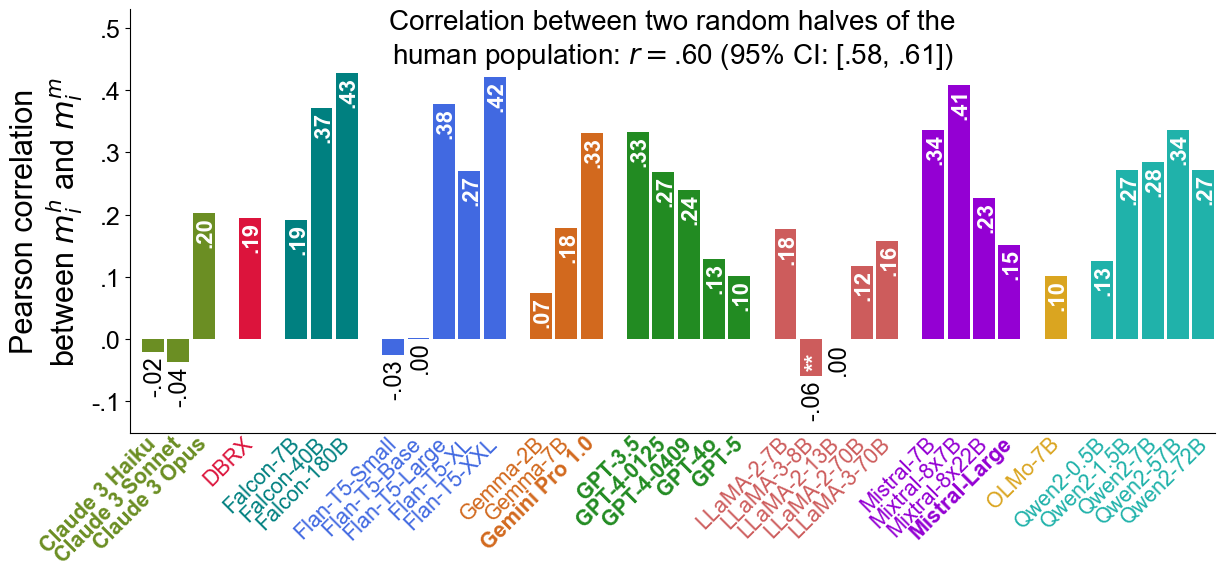

In [28]:
import re

s = stat_comm_models["statistic"]
p = stat_comm_models["pvalue_corrected"]


def ax_barh(ax, model_names, color, yticks_val, yticks):
    c = s.loc[model_names]
    max_yticksval = max(yticks_val) if len(yticks_val) > 0 else 0

    yvals = np.array(
        list(np.arange(max_yticksval + 1, max_yticksval + len(c) * 1.0 + 1, 1.1))
    )

    xvals = c.values
    for x, height, model_name in zip(yvals, xvals, model_names):
        ax.bar(x=[x], height=[height], color=color, width=0.95, alpha=1)

        pval = p[model_name]
        annot = ""
        if pval < 0.001:
            annot = "***"
        elif pval < 0.01:
            annot = "**"
        elif pval < 0.05:
            annot = "*"

        if height >= 0.05:
            ax.text(  # s=f"{round(height, 2)}"
                s=re.sub("0(?=[.])", "", ("%0.2f" % height)),
                y=height - 0.005,
                x=x + 0.08,
                va="top" if height < 0 else "top",
                ha="center",
                size=16,
                fontweight="bold" if height > 0.05 else None,
                rotation=90,
                color="white" if height > 0.05 else "black",
            )
        else:
            ax.text(  # s=f"{round(height, 2)}"
                s=re.sub("0(?=[.])", "", ("%0.2f" % height)),
                y=height - 0.005,
                x=x + 0.08,
                va="top",
                ha="center",
                size=17,
                fontweight=None,
                rotation=90,
                color="white" if height > 0.05 else "black",
            )
            if annot == "**":
                ax.text(  # s=f"{round(height, 2)}"
                    s=annot,
                    y=height + 0.01,
                    x=x + 0.2,
                    va="bottom",
                    ha="center",
                    size=17,
                    fontweight="bold",
                    rotation=90,
                    color="white",
                )

    yticks_val.extend(yvals)
    yticks.extend(c.index)
    yticks_val.append(max(yticks_val) + 1)
    yticks.append("")


fig, ax = plt.subplots(1, 1, figsize=(14, 5.5))

yticks_val = []
yticks = []

ax_barh(
    ax=ax,
    model_names=["Claude 3 Haiku", "Claude 3 Sonnet", "Claude 3 Opus"],
    color="olivedrab",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax, model_names=["DBRX"], color="crimson", yticks_val=yticks_val, yticks=yticks
)

ax_barh(
    ax=ax,
    model_names=["Falcon-7B", "Falcon-40B", "Falcon-180B"],
    color="teal",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=[
        "Flan-T5-Small",
        "Flan-T5-Base",
        "Flan-T5-Large",
        "Flan-T5-XL",
        "Flan-T5-XXL",
    ],
    color="royalblue",
    yticks_val=yticks_val,
    yticks=yticks,
)


ax_barh(
    ax=ax,
    model_names=["Gemma-2B", "Gemma-7B", "Gemini Pro 1.0"],
    color="chocolate",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=["GPT-3.5", "GPT-4-0125", "GPT-4-0409", "GPT-4o", "GPT-5"],
    color="forestgreen",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=[
        "LLaMA-2-7B",
        "LLaMA-3-8B",
        "LLaMA-2-13B",
        "LLaMA-2-70B",
        "LLaMA-3-70B",
    ],
    color="indianred",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=["Mistral-7B", "Mixtral-8x7B", "Mixtral-8x22B", "Mistral-Large"],
    color="darkviolet",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=["OLMo-7B"],
    color="goldenrod",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_barh(
    ax=ax,
    model_names=["Qwen2-0.5B", "Qwen2-1.5B", "Qwen2-7B", "Qwen2-57B", "Qwen2-72B"],
    color="lightseagreen",
    yticks_val=yticks_val,
    yticks=yticks,
)

sns.despine(ax=ax)
ax.set_ylabel("Pearson correlation\nbetween $m_i^h$ and $m_i^m$", size=22)
ax.set_ylim([-0.15, 0.53])

ticks = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
ax.set_yticks(ticks, [re.sub("0(?=[.])", "", ("%0.1f" % x)) for x in ticks], size=18)

for val, model_name in zip(np.array(yticks_val) + 0.3, yticks):

    if model_name in [
        "GPT-5",
        "GPT-4-0409",
        "GPT-4-0125",
        "GPT-4o",
        "GPT-3.5",
        "Claude 3 Haiku",
        "Claude 3 Sonnet",
        "Claude 3 Opus",
        "Mistral-Large",
        "Gemini Pro 1.0",
    ]:
        bold = True
    else:
        bold = False
    if model_name in model_to_color:
        color = model_to_color[model_name]
    else:
        color = "w"

    ax.text(
        x=val,
        y=ax.get_ylim()[0],
        s=model_name,
        va="top",
        ha="right",
        rotation=45,
        fontweight="bold" if bold else None,
        size=15.5,
        color=color,
    )

ax.set_xlim([0, 47])

ax.tick_params(axis="x", which="major", pad=0, size=-1, labelsize=13)
ax.set_xticks([])

# Humans correlation with humans
m, lo, hi = np.mean(res), np.percentile(res, 2.5), np.percentile(res, 97.5)
ax.text(
    x=0.5 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
    y=ax.get_ylim()[1],
    s=f"Correlation between two random halves of the\nhuman population: $r =${re.sub('0(?=[.])', '', ("%0.2f" % m))}"
    f" (95% CI: [{re.sub('0(?=[.])', '', ("%0.2f" % lo))}, {re.sub('0(?=[.])', '', ("%0.2f" % hi))}])",
    va="top",
    ha="center",
    rotation=0,
    size=20,
)

plt.savefig(
    "figures/simulated_commonsensicality_calibration/pearsonr_human_model.pdf",
    bbox_inches="tight",
)

plt.show()

### Predicting statement commonsensicality score in humans using ALL 34 models


In [29]:
import statsmodels.api as sm

# Predict human scores from model scores
X = statement_comm_only.drop(columns="Humans")
X = sm.add_constant(X)
y = statement_comm_only["Humans"]

model = sm.OLS(y, X).fit()
# R2
model.rsquared

np.float64(0.3796912604948175)

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Humans   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     76.44
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:03:53   Log-Likelihood:                -19500.
No. Observations:                4407   AIC:                         3.907e+04
Df Residuals:                    4371   BIC:                         3.930e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8327      4.100      0.447      0.655      -6.204       9.870
Claude 3 Haiku     -0.0170      0.013     -1.269      0.205      -0.043       0.009
Claude 3 Opus       0.0250      0.011      2.286      0.022       0.004       0.046
Claude 3 Sonnet    -0.0031      0.014     -0.216      0.829      -0.031       0.025
DBRX                0.0044      0.011      0.409      0.683      -0.017       0.025
Falcon-180B         0.2590      0.026      9.903      0.000       0.208       0.310
Falcon-40B          0.1671      0.058      2.894      0.004       0.054       0.280
Falcon-7B           0.0742      0.037      2.008      0.045       0.002       0.147
Flan-T5-Base       -0.0407      0.021     -1.937      0.053      -0.082       0.000
Flan-T5-Large       0.1273      0.016      8.043      0.000       0.096       0.158
Flan-T5-Small       0.0805      0.028      2.883      0.004       0.026       0.135
Flan-T5-XL          0.0117      0.016      0.718      0.473      -0.020       0.044
Flan-T5-XXL         0.2271      0.017     13.698      0.000       0.195       0.260
GPT-3.5             0.0253      0.014      1.746      0.081      -0.003       0.054
GPT-4-0125          0.0708      0.018      3.943      0.000       0.036       0.106
GPT-4-0409         -0.0005      0.016     -0.033      0.974      -0.031       0.030
GPT-4o             -0.0078      0.014     -0.569      0.570      -0.035       0.019
GPT-5              -0.0227      0.012     -1.892      0.059      -0.046       0.001
Gemini Pro 1.0      0.0153      0.015      1.024      0.306      -0.014       0.044
Gemma-2B           -0.0409      0.016     -2.632      0.009      -0.071      -0.010
Gemma-7B           -0.0036      0.014     -0.251      0.802      -0.032       0.025
LLaMA-2-13B         0.0428      0.014      3.058      0.002       0.015       0.070
LLaMA-2-70B         0.0724      0.014      5.269      0.000       0.045       0.099
LLaMA-2-7B         -0.0408      0.013     -3.167      0.002      -0.066      -0.016
LLaMA-3-70B        -0.0136      0.013     -1.045      0.296      -0.039       0.012
LLaMA-3-8B         -0.0207      0.015     -1.369      0.171      -0.050       0.009
Mistral-7B          0.0512      0.011      4.500      0.000       0.029       0.073
Mistral-Large      -0.0226      0.014     -1.631      0.103      -0.050       0.005
Mixtral-8x22B       0.0442      0.014      3.230      0.001       0.017       0.071
Mixtral-8x7B        0.0590      0.009      6.518      0.000       0.041       0.077
OLMo-7B            -0.0128      0.016     -0.810      0.418      -0.044       0.018
Qwen2-0.5B         -0.0386      0.028     -1.400      0.162      -0.093       0.015
Qwen2-1.5B         -0.0495      0.017     -2.947      0.003      -0.082      -0.017
Qwen2-57B           0.0910      0.015      5.989      0.000

In [31]:
y_pred_all = model.predict(X)

In [32]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

metrics = []

# KFold split
kf = KFold(n_splits=50, shuffle=True, random_state=100)
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    # No intercept because we added it manually before
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    # R2
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    metrics.append(r2)

50it [00:00, 223.18it/s]


In [33]:
np.mean(metrics)

np.float64(0.36107553150548194)

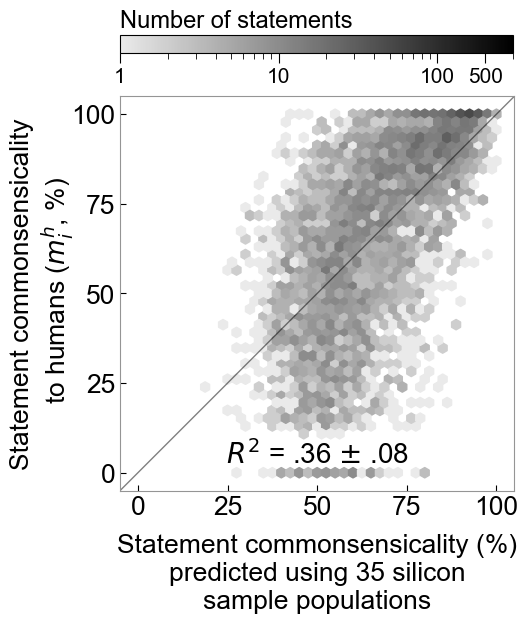

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import re

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(8, 1.5),
    height_ratios=(1.5, 8),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])

colors = [np.array((235, 235, 235)) / 256, "black"]  # RGB values for gray
custom_cmap = LinearSegmentedColormap.from_list("gray_orange", colors)

x = y_pred_all
y = y

hb = ax.hexbin(
    x=x,
    y=y,
    C=None,
    gridsize=40,
    mincnt=1,
    cmap=custom_cmap,
    xscale="linear",
    yscale="linear",
    bins="log",
    vmin=1,
    vmax=300,
    extent=(0, 100, 0, 100),
    marginals=False,
)

res = pearsonr(x, y, alternative="two-sided")

r, pval = res.statistic, res.pvalue

ax.set_xlim([-5, 105])
ax.set_ylim([-5, 105])
ax.plot([-100, 200], [-100, 200], color="black", linewidth=1, alpha=0.5)

ax.set_xlabel(
    f"Statement commonsensicality (%)\npredicted using 35 silicon\nsample populations",
    size=19,
    labelpad=10,
)
ax.set_ylabel(
    f"Statement commonsensicality\n to humans ($m_i^h$, %)", size=19, labelpad=-3
)

ax.text(
    x=50,
    y=5,
    s=f"$R^2$ = {re.sub('0(?=[.])', '', ('%0.2f' % np.mean(metrics)))} $\\pm$ {re.sub('0(?=[.])', '', ('%0.2f' % np.std(metrics)))}",
    va="center",
    ha="center",
    size=20,
)


ax.set_xticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
ax.set_yticks([0, 25, 50, 75, 100], [0, 25, 50, 75, 100])
ax.tick_params(axis="both", direction="in", size=4, labelsize=19)
ax.set_aspect("equal")

cbaxes = fig.add_axes([0.1, 0.83, 0.655, 0.03])
cb = plt.colorbar(
    hb,
    cax=cbaxes,
    ticks=[1, 10, 100, 200],
    orientation="horizontal",
    pad=0,
    aspect=100,
    fraction=0.1,
)

# cb.outline.set_visible(False)
cb.ax.tick_params(size=7, direction="out", which="major", color="black")
cb.ax.tick_params(size=4, direction="out", which="minor", color="black")

cb.ax.set_xticklabels([1, 10, 100, 500], size=15)
cb.ax.set_title(
    "Number of statements", size=17, rotation=0, x=0, pad=10, va="center", ha="left"
)

for spine in ax.spines.values():
    spine.set_edgecolor(np.array((150, 150, 150)) / 256)

plt.savefig(
    "figures/statement_comm_predicted_from_34_populations.pdf", bbox_inches="tight"
)

### Predict statement commonsensicality score in humans using human scores


In [35]:
# model.summary()

### Mean absolute error


In [36]:
model_name = "Falcon-180B"
y_pred = statement_comm_only[model_name]
y_true = statement_comm_only["Humans"]

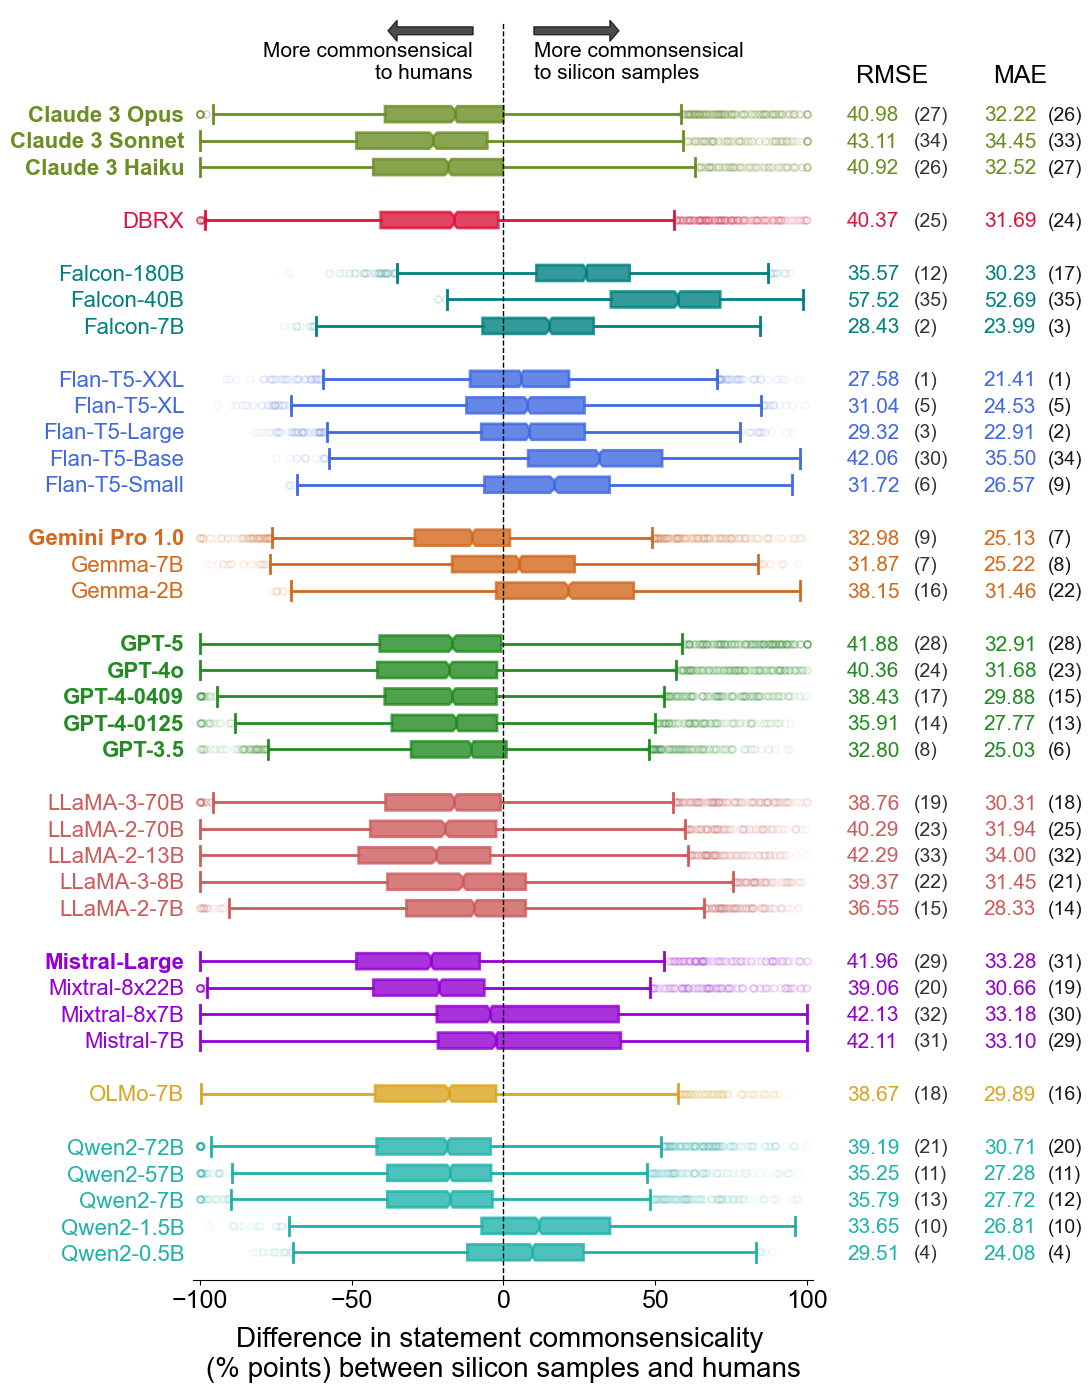

In [37]:
from scipy import stats
from matplotlib.colors import to_rgb
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1, 1, figsize=(8, 16.5))

yticks_val = []
yticks = []

rankings = pd.DataFrame(0.0, index=model_to_color.keys(), columns=["rmse", "mae"])
for model_name in model_to_color.keys():
    y_true = statement_comm_only[model_name]
    y_pred = statement_comm_only["Humans"]

    diff = y_pred - y_true
    rmse = np.sqrt(np.mean(diff**2))
    mae = np.mean(np.abs(diff))

    rankings.loc[model_name, "rmse"] = rmse
    rankings.loc[model_name, "mae"] = mae

rankings["rmse_rank"] = rankings["rmse"].rank().astype(int)
rankings["mae_rank"] = rankings["mae"].rank().astype(int)


def ax_scatter(ax, model_names, color, yticks_val, yticks):
    max_yticksval = max(yticks_val) if len(yticks_val) > 0 else 0
    yvals = np.array(
        list(range(max_yticksval + 1, max_yticksval + len(model_names) + 1))
    )

    for yval, model_name in zip(yvals[::-1], model_names[::-1]):
        y_true = statement_comm_only[model_name]
        y_pred = statement_comm_only["Humans"]
        diff = y_pred - y_true

        yval_rand = np.repeat(yval, len(diff)).astype(float)
        yval_rand += np.random.normal(0, 0.06, yval_rand.shape[0])

        if model_name in [
            "GPT-5",
            "GPT-4-0409",
            "GPT-4-0125",
            "GPT-4o",
            "GPT-3.5",
            "Claude 3 Haiku",
            "Claude 3 Sonnet",
            "Claude 3 Opus",
            "Mistral-Large",
            "Gemini Pro 1.0",
        ]:
            bold = True
        else:
            bold = False
        ax.text(
            x=-105,
            y=yval,
            s=model_name,
            size=16,
            ha="right",
            color=color,
            va="center",
            fontweight="bold" if bold else None,
        )

        bplot = ax.boxplot(
            x=diff,
            vert=False,
            positions=[yval + 0.05],
            widths=[0.6],
            showfliers=True,
            notch=True,
            flierprops=dict(alpha=0.07, markeredgecolor=color, markersize=5),
            medianprops=dict(color=color, linewidth=2),
            bootstrap=1000,
            boxprops=dict(color=color, linewidth=2),
            patch_artist=True,
            autorange=True,
            capprops=dict(linewidth=2, color=color),
            showcaps=True,
            capwidths=0.7,
            whiskerprops=dict(linewidth=2, color=color, alpha=1),
        )
        # fill with colors
        for patch in bplot["boxes"]:
            patch.set_facecolor(color)
            patch.set_alpha(0.8)

        rmse, rmse_rank = (
            rankings.loc[model_name, "rmse"],
            rankings.loc[model_name, "rmse_rank"],
        )
        ax.text(
            x=113, y=yval, s=f"{rmse:.2f}", va="center", ha="left", size=15, color=color
        )
        ax.text(
            x=135,
            y=yval,
            s="(" + str(rmse_rank) + ")",
            va="center",
            ha="left",
            size=14,
            color="black",
            alpha=0.8,
        )

        #         r2 = r2_score(y_true=y_true, y_pred=y_pred) * 100
        #         ax.text(x=168, y=yval, s=f"{r2:.2f}", va="center", ha="right", size=15, color=color)

        mae, mae_rank = (
            rankings.loc[model_name, "mae"],
            rankings.loc[model_name, "mae_rank"],
        )
        ax.text(
            x=158, y=yval, s=f"{mae:.2f}", va="center", ha="left", size=15, color=color
        )
        ax.text(
            x=179,
            y=yval,
            s="(" + str(mae_rank) + ")",
            va="center",
            ha="left",
            size=14,
            color="black",
            alpha=0.9,
        )

        rankings.loc[model_name, "rmse"] = rmse
        rankings.loc[model_name, "mae"] = mae

    yticks_val.extend(yvals)
    yticks.extend(model_names)
    yticks_val.append(max(yticks_val) + 1)
    yticks.append("")


ax_scatter(
    ax=ax,
    model_names=["Qwen2-0.5B", "Qwen2-1.5B", "Qwen2-7B", "Qwen2-57B", "Qwen2-72B"],
    color="lightseagreen",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=["OLMo-7B"],
    color="goldenrod",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=["Mistral-7B", "Mixtral-8x7B", "Mixtral-8x22B", "Mistral-Large"],
    color="darkviolet",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=[
        "LLaMA-2-7B",
        "LLaMA-3-8B",
        "LLaMA-2-13B",
        "LLaMA-2-70B",
        "LLaMA-3-70B",
    ],
    color="indianred",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=["GPT-3.5", "GPT-4-0125", "GPT-4-0409", "GPT-4o", "GPT-5"],
    color="forestgreen",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=["Gemma-2B", "Gemma-7B", "Gemini Pro 1.0"],
    color="chocolate",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=[
        "Flan-T5-Small",
        "Flan-T5-Base",
        "Flan-T5-Large",
        "Flan-T5-XL",
        "Flan-T5-XXL",
    ],
    color="royalblue",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax,
    model_names=["Falcon-7B", "Falcon-40B", "Falcon-180B"],
    color="teal",
    yticks_val=yticks_val,
    yticks=yticks,
)

ax_scatter(
    ax=ax, model_names=["DBRX"], color="crimson", yticks_val=yticks_val, yticks=yticks
)


ax_scatter(
    ax=ax,
    model_names=["Claude 3 Haiku", "Claude 3 Sonnet", "Claude 3 Opus"],
    color="olivedrab",
    yticks_val=yticks_val,
    yticks=yticks,
)

# ax.set_yticks(yticks_val, yticks, size=15, va="center", ha="right")
# ax.tick_params(axis="y", length=0)
ax.set_yticks([])
ax.tick_params(axis="x", which="major", labelsize=18)


ax.plot([0, 0], [0, 47.5], color="k", linestyle="--", linewidth=1)
ax.set_ylim(0, 48)
ax.set_xlim(-102, 102)

ax.text(
    x=10,
    y=46,
    s="More commonsensical\nto silicon samples",
    size=15,
    va="center",
    ha="left",
)
ax.arrow(
    x=10,
    y=47.2,
    dx=25,
    dy=0,
    width=0.3,
    head_width=0.8,
    head_length=3,
    shape="full",
    color="k",
    alpha=0.7,
)

ax.text(
    x=-10, y=46, s="More commonsensical\nto humans", size=15, va="center", ha="right"
)
ax.arrow(
    x=-10,
    y=47.2,
    dx=-25,
    dy=0,
    width=0.3,
    head_width=0.8,
    head_length=3,
    shape="full",
    color="k",
    alpha=0.7,
)

sns.despine(ax=ax, left=True)

ax.text(x=128, y=45.5, s=f"RMSE", va="center", ha="center", size=18, color="black")
# ax.text(x=158, y=44.5, s=f"R2", va="center", ha="center", size=16, color="black")
ax.text(x=170, y=45.5, s=f"MAE", va="center", ha="center", size=18, color="black")

ax.set_xlabel(
    "Difference in statement commonsensicality \n(% points) between silicon samples and humans",
    size=20,
    labelpad=10,
)

# ax.text(x=75, y=44.5, s="Model wins (%)", ha="right", va="center", size=15, color="firebrick")


plt.savefig(
    "figures/simulated_commonsensicality_calibration/errors_all.pdf",
    bbox_inches="tight",
)

plt.show()

In [38]:
rankings

,rmse,mae,rmse_rank,mae_rank
GPT-3.5,32.797982,25.030192,8,6
GPT-4-0125,35.906331,27.770785,14,13
GPT-4-0409,38.432535,29.876744,17,15
GPT-4o,40.362353,31.675414,24,23
GPT-5,41.881208,32.911092,28,28
LLaMA-2-7B,36.551749,28.325884,15,14
LLaMA-2-13B,42.294423,33.998652,33,32
LLaMA-2-70B,40.285920,31.936246,23,25
LLaMA-3-8B,39.370171,31.453581,22,21
LLaMA-3-70B,38.762977,30.309937,19,18


In [39]:
statements = pd.read_csv("data/statements_and_prompts.csv")
statements = statements["statement"]

In [40]:
model_name = "GPT-3.5"
idx = 529
print(statements[idx])
print("Consensus:", statement_comm_all.loc[model_name]["consensus"][idx])
print("Awareness:", statement_comm_all.loc[model_name]["awareness"][idx])
print(
    "Commonsensicality:", statement_comm_all.loc[model_name]["commonsensicality"][idx]
)

Experience is imperative to run a country.
Consensus: 89.71421423519162
Awareness: 39.556010630715186
Commonsensicality: 59.57127170048915


## Difference in statement commonsensicality between humans and model based 6 epistemic dimensions


In [41]:
statements = pd.read_csv("data/statements_and_prompts.csv")
dims = ["behavior", "everyday", "figure_of_speech", "judgment", "opinion", "reasoning"]

In [42]:
statements[statements["everyday"] == 1].sample(5)

,statement,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,category,elicitation,q1,q2,q3
1372,If john affects mary's health he would take ca...,0,1,0,0,0,1,Religion and belief systems,category response,"Consider the statement, ""If john affects mary'...","Consider the statement, ""If john affects mary'...","Consider the statement, ""If john affects mary'..."
2246,If we feel a little cold we might want to eat ...,1,1,0,1,1,1,Human activities,category response,"Consider the statement, ""If we feel a little c...","Consider the statement, ""If we feel a little c...","Consider the statement, ""If we feel a little c..."
3114,Something that might happen when you go to a r...,1,1,0,1,0,0,Human activities,Concept Net,"Consider the statement, ""Something that might ...","Consider the statement, ""Something that might ...","Consider the statement, ""Something that might ..."
398,Conservative values are the no brainer choice.,1,1,0,1,0,1,General reference,campaign email,"Consider the statement, ""Conservative values a...","Consider the statement, ""Conservative values a...","Consider the statement, ""Conservative values a..."
3770,Voting should not be made harder for americans.,1,1,1,0,1,1,Culture and the arts,news media,"Consider the statement, ""Voting should not be ...","Consider the statement, ""Voting should not be ...","Consider the statement, ""Voting should not be ..."


In [43]:
i = 86
print(statements.statement[i])
print(statement_comm_all.loc["Gemini Pro 1.0", "commonsensicality"][i])

A person doesn't want a low paying job.
5.291502622129181


In [44]:
statements["behavior"].value_counts()

behavior
1    2939
0    1468
Name: count, dtype: int64

In [45]:
statements[statements["behavior"] == 1].sample(10).statement.tolist()

['There are benefits to supporting findley including monetary gains.',
 'If you want to program then you should learn a programming language.',
 "If alex is driving alex's car on the highway they're going 30 mph over the speed limit.",
 'If max achieves sam effect then sam feels happy.',
 "If max asks max's friends for help then max feels taken care of.",
 'Something you find on a table is a tablecloth.',
 'If john spends most of his time with mary they are enjoying their time.',
 'Someone terrible at math will apply to be a math teacher.',
 'If alex gives sam instruction it will most likely be wrong.',
 'Wisdom is like a baobab tree it is hard for an individual to embrace it.']

In [46]:
x = pd.DataFrame(
    zip(
        statements.statement,
        statement_comm_all.loc["Gemini Pro 1.0", "commonsensicality"],
    )
)
x[statements["figure_of_speech"] == 0].sort_values(1).head(50)

,0,1
1499,If mary joins the chess club she will learn ho...,0.000000
906,If alex discusses later in the chapter they wi...,0.000000
1297,If alex turns things around he she would keep ...,0.000000
65,A man with no legs cannot run.,0.000000
4073,We should support andy ruff for congress.,0.000000
2036,If max adopts a child then max intends to to f...,0.000000
1593,If max accepts sam invitation then max buys a ...,0.000000
1595,If max accepts sam invitation then max feels g...,0.000000
1603,If max accepts sam invitation then max needs b...,0.000000
417,Cynicism is an unpleasant way of saying the tr...,0.000000


In [47]:
from numba import njit, prange

np.random.seed(100)

dims = ["behavior", "everyday", "figure_of_speech", "judgment", "opinion", "reasoning"]

diff_by_dim_humans = pd.DataFrame(columns=["data", "mean"])
diff_by_dim_models_all = {
    model_name: pd.DataFrame(columns=["data", "mean"])
    for model_name in all_models.keys()
}


@njit(parallel=True)
def bootstrap(vals, dim, n_boots=1000, standardize=False):
    diff = np.zeros(n_boots, dtype=float)
    #     # standardize
    #     vals = vals / np.std(vals)
    for i in range(n_boots):
        idx = np.random.choice(np.arange(vals.shape[0]), len(vals))
        val_pos = vals[idx][dim[idx] == 1]
        val_neg = vals[idx][dim[idx] == 0]
        if standardize:
            pooled_sd = np.sqrt(
                (
                    np.var(val_pos) * (len(val_pos) - 1)
                    + np.var(val_neg) * (len(val_neg) - 1)
                )
                / (len(val_pos) + len(val_neg) - 2)
            )
        else:
            pooled_sd = 1
        diff[i] = (val_pos.mean() - val_neg.mean()) / pooled_sd
    return diff


for i, dim in enumerate(dims):
    if dim == "behavior":
        dim_ = "Physical\n - Social"
    elif dim == "everyday":
        dim_ = "Everyday\n - Abstract"
    elif dim == "figure_of_speech":
        dim_ = "Literal language\n - Figure of speech"
    elif dim == "judgment":
        dim_ = "Positive\n - Normative"
    elif dim == "opinion":
        dim_ = "Fact\n - Opinion"
    elif dim == "reasoning":
        dim_ = "Knowledge\n - Reasoning"

    # Humans
    human = statement_comm_all.loc["Humans", "commonsensicality"]
    if dim == "everyday":
        diff_humans = bootstrap(human, statements[dim].to_numpy(), standardize=False)
    else:
        diff_humans = bootstrap(
            human, (1 - statements[dim]).to_numpy(), standardize=False
        )

    diff_by_dim_humans.loc[dim_, "data"] = diff_humans
    diff_by_dim_humans.loc[dim_, "mean"] = diff_humans.mean()

    # Models
    for model_name in tqdm(all_models.keys(), leave=False):
        model = statement_comm_all.loc[model_name, "commonsensicality"]

        if dim == "everyday":
            diff_models = bootstrap(
                model, statements[dim].to_numpy(), standardize=False
            )
        else:
            diff_models = bootstrap(
                model, (1 - statements[dim]).to_numpy(), standardize=False
            )

        diff_by_dim_models_all[model_name].loc[dim_, "data"] = diff_models
        diff_by_dim_models_all[model_name].loc[dim_, "mean"] = diff_models.mean()

diff_by_dim_humans = diff_by_dim_humans.sort_values("mean", ascending=True)
# diff_by_dim_models = diff_by_dim_models.sort_values("mean", ascending=True)

In [48]:
diff_by_dim_humans

,data,mean
Everyday\n - Abstract,"[5.166529558821885, 5.8953081334110635, 4.4556...",4.828092
Knowledge\n - Reasoning,"[7.8239925827459516, 6.956898886902373, 8.1202...",6.662266
Positive\n - Normative,"[8.671769463237922, 6.0869590343718585, 7.3318...",7.126228
Literal language\n - Figure of speech,"[7.594404343311737, 8.091299700731355, 8.74078...",7.254854
Physical\n - Social,"[8.937195790441628, 8.937625010634157, 8.68965...",7.639481
Fact\n - Opinion,"[9.317076436770627, 10.08313088258938, 8.63888...",9.423962


In [49]:
diff_by_dim_humans = diff_by_dim_humans.sort_values("mean", ascending=True)
model_to_color = {
    "GPT-3.5": "forestgreen",
    "GPT-4-0125": "forestgreen",
    "GPT-4-0409": "forestgreen",
    "GPT-4o": "forestgreen",
    "GPT-5": "forestgreen",
    "LLaMA-2-7B": "indianred",
    "LLaMA-2-13B": "indianred",
    "LLaMA-2-70B": "indianred",
    "LLaMA-3-8B": "indianred",
    "LLaMA-3-70B": "indianred",
    "Flan-T5-Small": "royalblue",
    "Flan-T5-Base": "royalblue",
    "Flan-T5-Large": "royalblue",
    "Flan-T5-XL": "royalblue",
    "Flan-T5-XXL": "royalblue",
    "Gemma-2B": "chocolate",
    "Gemma-7B": "chocolate",
    "Gemini Pro 1.0": "chocolate",
    "Mistral-7B": "darkviolet",
    "Mixtral-8x7B": "darkviolet",
    "Mixtral-8x22B": "darkviolet",
    "Mistral-Large": "darkviolet",
    "OLMo-7B": "goldenrod",
    "Falcon-7B": "teal",
    "Falcon-40B": "teal",
    "Falcon-180B": "teal",
    "Claude 3 Haiku": "olivedrab",
    "Claude 3 Sonnet": "olivedrab",
    "Claude 3 Opus": "olivedrab",
    "DBRX": "crimson",
    "Qwen2-0.5B": "lightseagreen",
    "Qwen2-1.5B": "lightseagreen",
    "Qwen2-7B": "lightseagreen",
    "Qwen2-57B": "lightseagreen",
    "Qwen2-72B": "lightseagreen",
}

In [50]:
from matplotlib import patches


def plot_diff_by_dim(model_name, ax):
    diff_by_dim_models = diff_by_dim_models_all[model_name]
    model_color = model_to_color[model_name]

    xmin = -0.0001
    xmax = 0.00001

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * 1.2, 1.2), diff_by_dim_humans.index
    ):

        # MODELS
        diff = diff_by_dim_models.loc[dim, "data"]
        yvals = np.array([i] * len(diff), dtype=float)
        yvals += np.random.rand(yvals.shape[0]) * 0.3 - 0.15
        ax.scatter(diff, yvals - 0.2, color=model_color, alpha=0.04, s=2)
        xmin = min(xmin, diff.min())
        xmax = max(xmax, diff.max())

        # Indicate mean
        mean = diff.mean()
        ax.scatter([mean], [i - 0.2], color=model_color, marker="D", s=60)

        ci_thickness = 0.1
        lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
        ax.plot([lo, hi], [i - 0.2, i - 0.2], color=model_color, linewidth=2.5)
        ax.plot(
            [lo, lo],
            [i - ci_thickness - 0.2, i + ci_thickness - 0.2],
            color=model_color,
            linewidth=2.5,
        )
        ax.plot(
            [hi, hi],
            [i - ci_thickness - 0.2, i + ci_thickness - 0.2],
            color=model_color,
            linewidth=2.5,
        )

        # HUMANS
        diff = diff_by_dim_humans.loc[dim, "data"]
        yvals = np.array([i] * len(diff), dtype=float)
        yvals += np.random.rand(yvals.shape[0]) * 0.3 - 0.15
        ax.scatter(diff, yvals + 0.2, color="black", alpha=0.04, s=2)
        xmin = min(xmin, diff.min())
        xmax = max(xmax, diff.max())

        # Indicate mean
        mean = diff.mean()
        ci_thickness = 0.1
        lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
        ax.scatter([mean], [i + 0.2], color="k", marker="s", s=60)
        ax.plot([lo, hi], [i + 0.2, i + 0.2], color="k", linewidth=2.5)
        ax.plot(
            [lo, lo],
            [i - ci_thickness + 0.2, i + ci_thickness + 0.2],
            color="k",
            linewidth=2.5,
        )
        ax.plot(
            [hi, hi],
            [i - ci_thickness + 0.2, i + ci_thickness + 0.2],
            color="k",
            linewidth=2.5,
        )

    #     print(dim, "M = ", mean, f" CI = [{lo}, {hi}]")

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * 1.2, 1.2), diff_by_dim_humans.index
    ):
        text_right, text_left = dim.split("\n - ")
        ax.text(
            x=xmin,
            y=i,
            s=text_left,
            ha="right",
            va="center",
            size=18,
            color="k",
        )
        ax.text(
            x=xmax,
            y=i,
            s=text_right,
            ha="left",
            va="center",
            size=18,
            color="k",
        )

        ax.plot([xmin, xmax], [i, i], color="k", linestyle=(0, (1, 3)), alpha=0.4)

    # ax.set_yticks(range(len(diff_by_dim_humans)), diff_by_dim_humans.index, size=12)
    ax.set_yticks([])
    ax.set_xlim([xmin, xmax])

    ax.tick_params(axis="y", length=0)
    ax.tick_params(axis="x", which="major", labelsize=22)
    sns.despine(ax=ax, top=True, left=True, right=True, bottom=False)
    ax.set_xlabel("Difference in commonsensicality (% points)", size=22, labelpad=10)
    [line.set_zorder(3) for line in ax.lines]

    # ax.set_ylim(-0.8, 5.5)
    ax.tick_params(axis="y", which="major", labelsize=20)
    ax.plot([0, 0], [-0.6, 6.6], color="k", linestyle="--")

    ax.text(
        x=diff_by_dim_models.loc["Fact\n - Opinion", "data"].mean(),
        y=5.65,
        s="Model",
        color=model_color,
        size=16,
        ha="center",
        va="top",
    )
    ax.text(
        x=diff_by_dim_humans.loc["Fact\n - Opinion", "data"].mean(),
        y=6.34,
        s="Humans",
        color="black",
        size=16,
        ha="center",
        va="bottom",
    )

    # plt.savefig("figures/humans_models_statement_comm_diff_by_dim_v3.pdf", bbox_inches="tight")

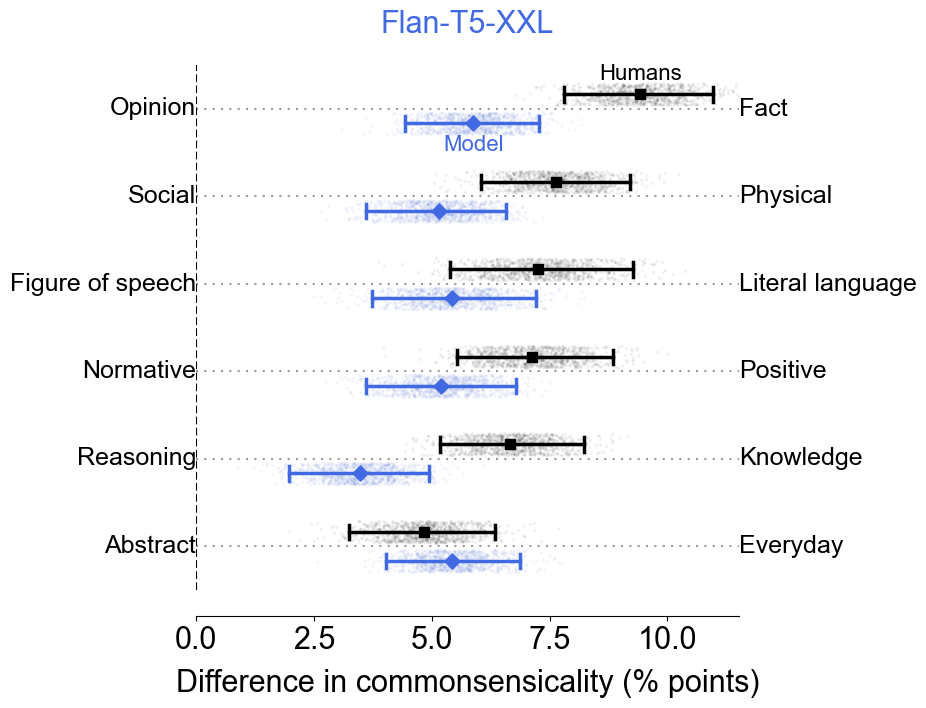

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7.5))

model_name = "Flan-T5-XXL"

bold = model_name in [
    "GPT-4-0409",
    "GPT-4-0125",
    "GPT-4o",
    "GPT-3.5",
    "Claude 3 Haiku",
    "Claude 3 Sonnet",
    "Claude 3 Opus",
    "Mistral-Large",
    "Gemini Pro 1.0",
]

ax.set_title(
    model_name,
    color=model_to_color[model_name],
    fontweight="bold" if bold else None,
    size=22,
    pad=0,
)

plot_diff_by_dim(model_name, ax)

plt.show()

In [52]:
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_diff_by_dim_3models(model_names, ax):
    xmin = -0.0001
    xmax = 0.00001

    line = ax.axvline(0, color="k", linestyle="--", alpha=0.7, zorder=1)

    legends = []

    # Total number of plots
    n = len(model_names) + 1  # +1 for humans
    n_range = np.linspace(
        -((n // 2)) * 0.2 - (0 if n % 2 else -1) * 0.1,
        ((n // 2)) * 0.2 + (0 if n % 2 else -1) * 0.1,
        n,
    )
    total_width = n_range.max() - n_range.min()
    offset = n / 4

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * offset, offset), diff_by_dim_humans.index
    ):
        for delta, marker, model_name in zip(
            n_range[:0:-1], ["o", "D", "^", "X", "p", "v", "H"], model_names
        ):
            diff_by_dim_models = diff_by_dim_models_all[model_name]
            model_color = model_to_color[model_name]
            diff = diff_by_dim_models.loc[dim, "data"]
            yvals = np.array([i] * len(diff), dtype=float)
            yvals += np.random.rand(yvals.shape[0]) * 0.18 - 0.09
            ax.scatter(
                diff, yvals - delta, color=model_color, alpha=0.03, s=2, zorder=1
            )
            xmin = min(xmin, diff.min())
            xmax = max(xmax, diff.max())
            mean = diff.mean()
            ax.scatter(
                [mean], [i - delta], color=model_color, marker=marker, s=150, zorder=10
            )

            ci_thickness = 0.06
            lw = 2
            lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
            ax.plot(
                [lo + 0.001, hi - 0.001],
                [i - delta, i - delta],
                color=model_color,
                linewidth=lw,
                alpha=0.9,
            )
            ax.plot(
                [lo, lo],
                [i - ci_thickness - delta, i + ci_thickness - delta],
                color=model_color,
                linewidth=lw,
                alpha=0.9,
            )
            ax.plot(
                [hi, hi],
                [i - ci_thickness - delta, i + ci_thickness - delta],
                color=model_color,
                linewidth=lw,
                alpha=0.9,
            )

            if i == 0:
                legends.append(
                    Line2D(
                        [0],
                        [0],
                        marker=marker,
                        color="w",
                        markerfacecolor=model_color,
                        markersize=20,
                        label=model_name,
                    )
                )

        #             if model_name == "GPT-4o":
        #                 print(dim, end="\t")
        #                 print(f"{mean}, [{lo}, {hi}]")

        # HUMANS
        diff = diff_by_dim_humans.loc[dim, "data"]
        yvals = np.array([i] * len(diff), dtype=float)
        yvals += np.random.rand(yvals.shape[0]) * 0.18 - 0.09
        ax.scatter(diff, yvals + n_range[-1], color="black", alpha=0.03, s=2, zorder=2)
        xmin = min(xmin, diff.min())
        xmax = max(xmax, diff.max())

        # Indicate mean
        mean = diff.mean()
        ci_thickness = 0.06
        lw = 2
        lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
        ax.scatter([mean], [i + n_range[-1]], color="k", marker="s", s=150, zorder=10)
        if i == 0:
            legends.append(
                Line2D(
                    [0],
                    [0],
                    marker="s",
                    color="w",
                    markerfacecolor="k",
                    markersize=20,
                    label="Humans",
                )
            )
        ax.plot(
            [lo + 0.001, hi - 0.001],
            [i + n_range[-1], i + n_range[-1]],
            color="k",
            linewidth=lw,
            alpha=0.9,
        )
        ax.plot(
            [lo, lo],
            [i - ci_thickness + n_range[-1], i + ci_thickness + n_range[-1]],
            color="k",
            linewidth=lw,
            alpha=0.9,
        )
        ax.plot(
            [hi, hi],
            [i - ci_thickness + n_range[-1], i + ci_thickness + n_range[-1]],
            color="k",
            linewidth=lw,
            alpha=0.9,
        )

        print(dim, end="\t")
        print(f"{mean}, [{lo}, {hi}]")

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * offset, offset), diff_by_dim_humans.index
    ):
        text_right, text_left = dim.split("\n - ")
        if text_right == "Literal language":
            text_right = "Literal\nlanguage"
        if text_left == "Figure of speech":
            text_left = "Figure of\nspeech"
        ax.text(
            x=xmin - 0.1,
            y=i,
            s=text_left,
            ha="right",
            va="center",
            size=17,
            color="k",
        )
        ax.text(
            x=xmax + 0.1,
            y=i,
            s=text_right,
            ha="left",
            va="center",
            size=17,
            color="k",
        )

    for j, (i, dim) in enumerate(
        zip(
            np.arange(0, len(diff_by_dim_humans) * offset, offset)[1:],
            diff_by_dim_humans.index,
        )
    ):
        if j % 2 == 0:
            ax.fill_between(
                [xmin, xmax],
                [i - offset / 2, i - offset / 2],
                [i + offset / 2, i + offset / 2],
                color="k",
                alpha=0.03,
            )
    ax.set_yticks([])
    ax.set_xlim([xmin, xmax])

    ax.tick_params(axis="y", length=0)
    ax.tick_params(axis="x", which="major", labelsize=18)
    sns.despine(ax=ax, top=True, left=True, right=True, bottom=False)
    ax.set_xlabel(
        "Average difference in statement\ncommonsensicality (% points)",
        size=20,
        labelpad=10,
    )
    [line.set_zorder(3) for line in ax.lines]

    # ax.set_ylim(-0.8, 5.5)
    ax.tick_params(axis="y", which="major", labelsize=22)

    bottom = -offset / 2
    top = (len(diff_by_dim_humans) - 1) * offset + offset / 2
    ax.set_ylim([bottom, top + 0.01])

    ncol = 2
    nrow = n // ncol
    legends_new = []
    legends = np.array(legends)
    for i in range(len(legends) // ncol):
        legends_new.extend(legends[i::nrow])
    ax.legend(
        handles=list(legends)[::-1],  # list(legends_new)[::-1],
        ncol=n // 2,
        bbox_to_anchor=(0.5, -0.15),
        fontsize=18,
        labelcolor="markerfacecolor",
        frameon=False,
        numpoints=1,
        loc="center",
    )

Everyday
 - Abstract	4.828091894860819, [3.242955587617115, 6.332733588006899]
Knowledge
 - Reasoning	6.662265652672395, [5.173262707051499, 8.230902587992542]
Positive
 - Normative	7.126228233135352, [5.534593383019294, 8.83990243986657]
Literal language
 - Figure of speech	7.254853539228525, [5.380317643216548, 9.265038115425128]
Physical
 - Social	7.639480904221122, [6.0396018998812275, 9.198467843941904]
Fact
 - Opinion	9.42396189451421, [7.799858830372006, 10.980747903387376]


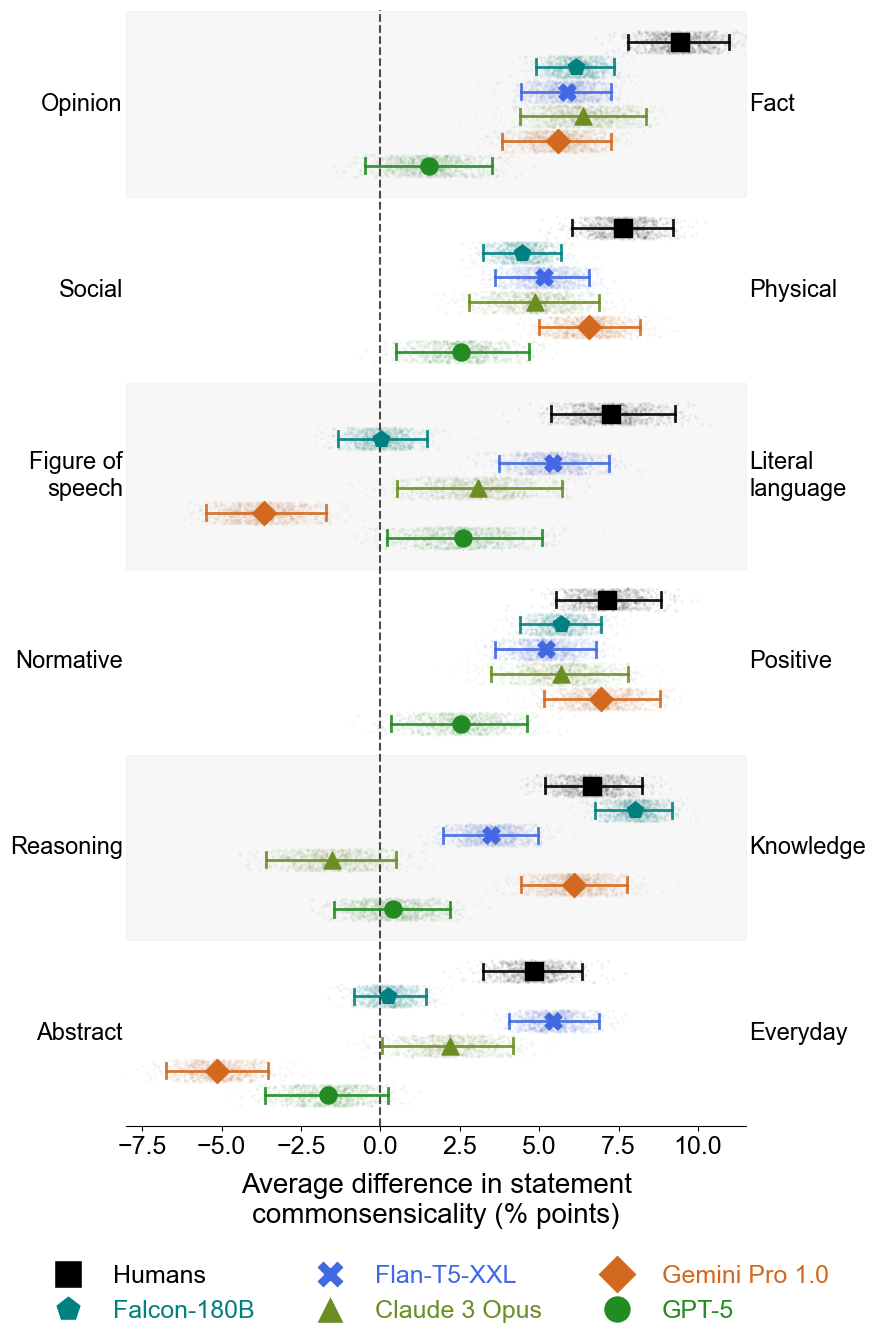

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 14.5))
plot_diff_by_dim_3models(
    ["Falcon-180B", "Flan-T5-XXL", "Claude 3 Opus", "Gemini Pro 1.0", "GPT-5"][::-1],
    ax=ax,
)

plt.savefig(
    "figures/collective_diff_by_dim_multiple_models.png", bbox_inches="tight", dpi=300
)
plt.show()

In [54]:
from matplotlib import patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_diff_by_dim_3models_no_scatter(model_names, ax):
    xmin = -0.0001
    xmax = 0.00001

    line = ax.axvline(0, color="k", linestyle="--", alpha=0.7, zorder=1)

    legends = []

    # Total number of plots
    n = len(model_names) + 1  # +1 for humans
    n_range = np.linspace(
        -((n // 2)) * 0.2 - (0 if n % 2 else -1) * 0.1,
        ((n // 2)) * 0.2 + (0 if n % 2 else -1) * 0.1,
        n,
    )
    total_width = n_range.max() - n_range.min()
    offset = n / 4

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * offset, offset), diff_by_dim_humans.index
    ):
        for delta, marker, model_name in zip(
            n_range[:0:-1], ["o", "D", "^", "X", "p", "v", "H"], model_names
        ):
            diff_by_dim_models = diff_by_dim_models_all[model_name]
            model_color = model_to_color[model_name]
            diff = diff_by_dim_models.loc[dim, "data"]
            yvals = np.array([i] * len(diff), dtype=float)
            yvals += np.random.rand(yvals.shape[0]) * 0.18 - 0.09
            # ax.scatter(diff, yvals - delta, color=model_color, alpha=0.03, s=2, zorder=1)
            xmin = min(xmin, diff.min())
            xmax = max(xmax, diff.max())
            mean = diff.mean()
            ax.scatter(
                [mean],
                [i - delta],
                color=model_color,
                marker=marker,
                s=280 if marker != "D" else 170,
                zorder=10,
                edgecolor="white",
                alpha=1,
            )

            ci_thickness = 0.06
            lw = 2.5

            lo, hi = np.percentile(diff, q=25), np.percentile(diff, q=75)
            ax.plot(
                [lo, hi],
                [i - delta, i - delta],
                color=model_color,
                linewidth=lw * 1.8,
                alpha=0.8,
            )

            lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
            ax.plot(
                [lo, hi],
                [i - delta, i - delta],
                color=model_color,
                linewidth=lw,
                alpha=0.8,
            )

            if i == 0:
                legends.append(
                    Line2D(
                        [0],
                        [0],
                        marker=marker,
                        color="w",
                        markerfacecolor=model_color,
                        markersize=21 if marker != "D" else 15,
                        label=model_name,
                    )
                )

            if model_name == "Falcon-180B":
                print(dim, end="\t")
                print(f"{mean}, [{lo}, {hi}]")

        # HUMANS
        diff = diff_by_dim_humans.loc[dim, "data"]
        yvals = np.array([i] * len(diff), dtype=float)
        yvals += np.random.rand(yvals.shape[0]) * 0.18 - 0.09
        # ax.scatter(diff, yvals + n_range[-1], color="black", alpha=0.03, s=2, zorder=2)
        xmin = min(xmin, diff.min())
        xmax = max(xmax, diff.max())

        # Indicate mean
        mean = diff.mean()
        ci_thickness = 0.06
        lw = 2.5

        lo, hi = np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)
        ax.scatter(
            [mean],
            [i + n_range[-1]],
            color="k",
            marker="s",
            s=150,
            zorder=10,
            edgecolor="white",
        )
        if i == 0:
            legends.append(
                Line2D(
                    [0],
                    [0],
                    marker="s",
                    color="w",
                    markerfacecolor="k",
                    markersize=20,
                    label="Humans",
                )
            )
        ax.plot(
            [lo, hi],
            [i + n_range[-1], i + n_range[-1]],
            color="k",
            linewidth=lw,
            alpha=0.8,
        )

        lo, hi = np.percentile(diff, q=25), np.percentile(diff, q=75)
        ax.plot(
            [lo, hi],
            [i + n_range[-1], i + n_range[-1]],
            color="k",
            linewidth=lw * 1.8,
            alpha=0.8,
        )

    for i, dim in zip(
        np.arange(0, len(diff_by_dim_humans) * offset, offset), diff_by_dim_humans.index
    ):
        text_right, text_left = dim.split("\n - ")
        if text_right == "Literal language":
            text_right = "Literal\nlanguage"
        if text_left == "Figure of speech":
            text_left = "Figure of\nspeech"
        ax.text(
            x=xmin - 0.1,
            y=i,
            s=text_left,
            ha="right",
            va="center",
            size=20,
            color="k",
        )
        ax.text(
            x=xmax + 0.1,
            y=i,
            s=text_right,
            ha="left",
            va="center",
            size=20,
            color="k",
        )

    for j, (i, dim) in enumerate(
        zip(
            np.arange(0, len(diff_by_dim_humans) * offset, offset)[1:],
            diff_by_dim_humans.index,
        )
    ):
        if j % 2 == 0:
            ax.fill_between(
                [xmin, xmax],
                [i - offset / 2, i - offset / 2],
                [i + offset / 2, i + offset / 2],
                color="k",
                alpha=0.04,
            )
    ax.set_yticks([])
    ax.set_xlim([xmin, xmax])

    ax.tick_params(axis="y", length=0)
    ax.set_xticks(
        [-7.5, -5.0, -2.5, 0.0, 2.5, 5.0, 7.5, 10.0],
        [-7.5, -5.0, -2.5, 0.0, 2.5, 5.0, 7.5, 10.0],
    )
    ax.tick_params(axis="x", which="major", labelsize=22)
    sns.despine(ax=ax, top=True, left=True, right=True, bottom=False)
    ax.set_xlabel(
        "Average difference in statement\ncommonsensicality (% points)",
        size=25,
        labelpad=15,
    )
    [line.set_zorder(3) for line in ax.lines]

    # ax.set_ylim(-0.8, 5.5)
    ax.tick_params(axis="y", which="major", labelsize=22)

    bottom = -offset / 2
    top = (len(diff_by_dim_humans) - 1) * offset + offset / 2
    ax.set_ylim([bottom, top + 0.01])

    ncol = 2
    nrow = n // ncol
    legends_new = []
    legends = np.array(legends)
    for i in range(len(legends) // ncol):
        legends_new.extend(legends[i::nrow])
    ax.legend(
        handles=list(legends)[::-1],  # list(legends_new)[::-1],
        ncol=n // 3,
        bbox_to_anchor=(0.5, 1.07),
        fontsize=22,
        labelcolor="markerfacecolor",
        frameon=False,
        numpoints=1,
        loc="center",
    )

Everyday
 - Abstract	0.24801991812133004, [-0.8436540079739556, 1.4324027490462123]
Knowledge
 - Reasoning	8.003332494107227, [6.771022274385001, 9.196783523105267]
Positive
 - Normative	5.686590781607357, [4.400710431814998, 6.961365098318331]
Literal language
 - Figure of speech	0.03147047224604083, [-1.320096457538897, 1.45991913172647]
Physical
 - Social	4.454809248543935, [3.232324349649661, 5.685236671290265]
Fact
 - Opinion	6.160017247025735, [4.907711033623029, 7.343261198876941]


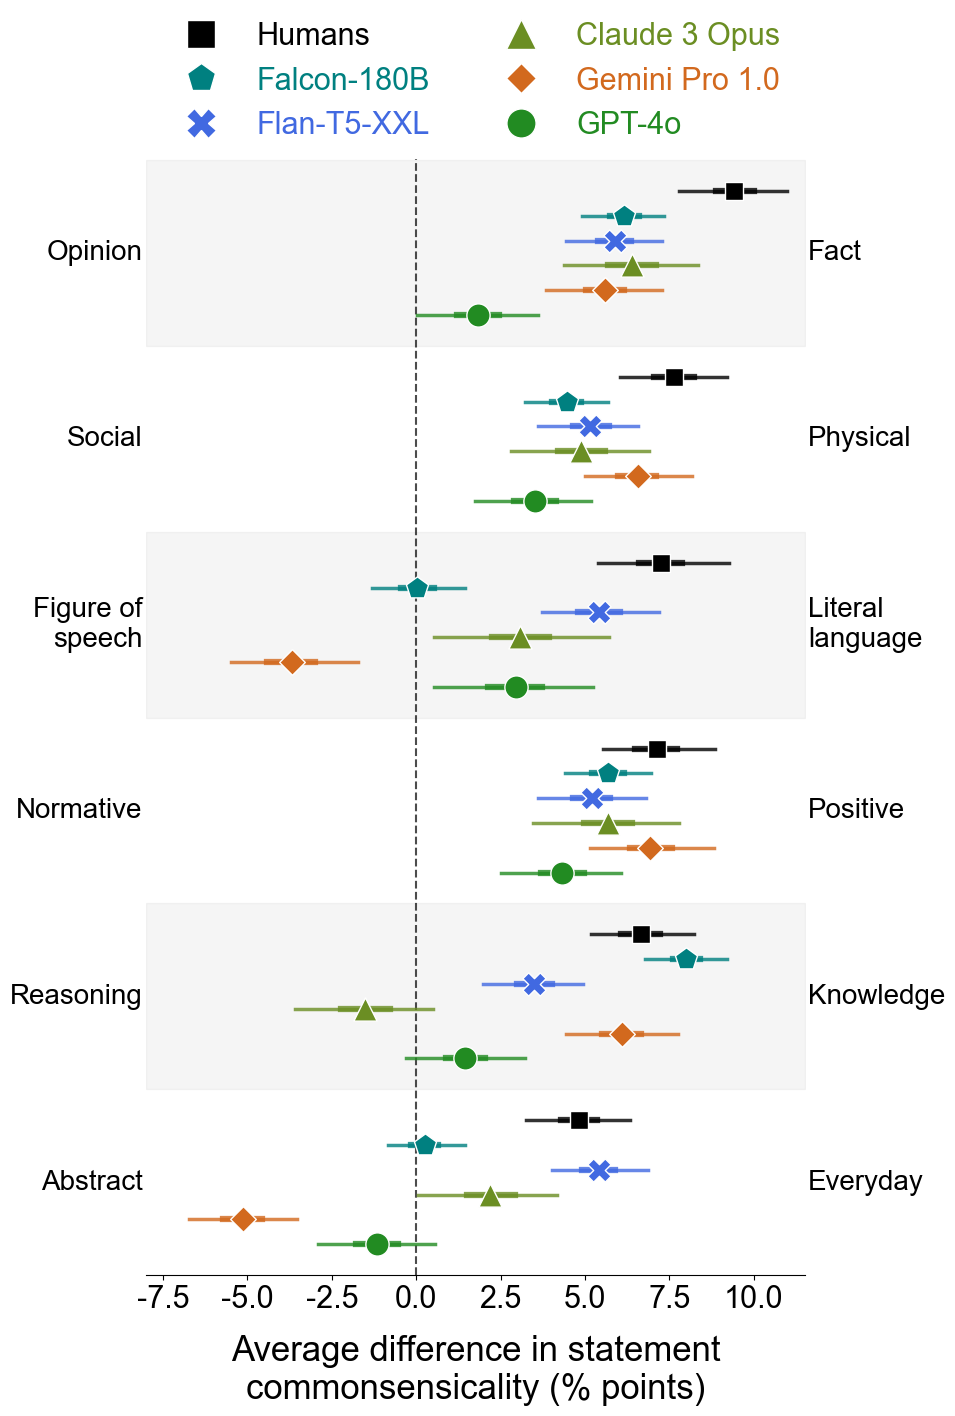

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8.5, 14.5))
plot_diff_by_dim_3models_no_scatter(
    ["Falcon-180B", "Flan-T5-XXL", "Claude 3 Opus", "Gemini Pro 1.0", "GPT-4o"][::-1],
    ax=ax,
)

plt.savefig(
    "figures/collective_diff_by_dim_multiple_models.pdf", bbox_inches="tight", dpi=300
)